### What even is an average?
For this project, a ounce of care should most likely be taken on what we mean when we say _RMSE_ as there are multiple ways one could define, particularly when taking zonal/meridional averages as well as averages over ensembles.


In [1]:
import os
import re 
import dask 
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import cartopy.crs as ccrs



In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35924,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:39645,Total threads: 2
Dashboard: http://127.0.0.1:34399/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37337,


In [3]:
NAME = 'jan'
FILE = 'jan'

BASE_DIR = f"/scratch/users/robcking/am4_error_growth_full/{FILE}"


In [4]:
full_memberlist = sorted(glob(os.path.join(BASE_DIR,'**','atmos_4xdaily.nc')),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
full_members =  xr.open_mfdataset(full_memberlist,combine='nested',concat_dim='members',chunks={'time':10,'pfull':'auto','grid_yt':'auto'}).isel(time=slice(250))
full_members = full_members.u_ref## Just use ucomp
full_members

AttributeError: 'NoneType' object has no attribute 'group'

### Method 1) Default
In the above $N$ is the number of _ensemble_ members
The current way we calculate the zonal averaged RMSE is via the following form:
$$
zonalRMSE = \frac{1}{N_{\lambda}}\sum_{\lambda} \frac{1}{N} \sum_{i}^N \sqrt{ \frac{1}{N-1}  \sum_{j}^{N-1} (y^{\lambda}_{i} -y^{\lambda}_{j})^2 }
$$

In [7]:
def zonal_rmse(u):
    rmse_list = []
    for i in range(len(u.members)):
        ref = u.isel(members=i)
        members = u.drop_isel(members=i)
        square_residual = (members -ref)**2
        rmse_i= np.sqrt(square_residual.mean(dim='members'))
        rmse_list.append(rmse_i)
    avg_ens_rmse = xr.concat(rmse_list,dim='members').mean(dim='members')
    return avg_ens_rmse.mean(dim='grid_xt') 
    

### Method 2) Diagonal
$$ 
RMSE = \frac{1}{N_{\lambda}}\sum_{\lambda} \frac{1}{N-1} \sqrt{  \sum_{i}^{N}\sum_{j}^{N} (y^{\lambda}_{i} -y^{\lambda}_{j})^2 }
$$

In [8]:
def diagonal_rmse(u):
    N = len(u.members)
    rmse= np.sqrt(((u.expand_dims({'members2':20},axis=0) - u.rename({'members':'members2'}).expand_dims({'members':20},axis=1))**2).sum(dim=['members','members2']))/(N-1)
    return rmse.mean(dim='grid_xt')
    
    

### Method 3) Square Residuals all the way
$$
RMSE = \sqrt{\frac{1}{N_{\lambda}} \sum_{\lambda}\sum(y^{\lambda}_{i} - y^{\lambda}_{j})^2}
$$

In [9]:
def square_residual_ftw(u):
    N = len(u.members)
    Nlambda = len(u.grid_xt)
    residuals = []
    for i in range(N):
        ref = u.isel(members=i)
        members = u.drop_isel(members=i)
        square_residual = (members -ref)**2
        residuals.append(square_residual.sum(dim='members'))
    ens_residuals = xr.concat(residuals,dim='members').sum(dim='members')
    return np.sqrt(ens_residuals.sum(dim='grid_xt')/(N*(N-1)*Nlambda))

### Method 4) Zonal average first

In [24]:
def zonal_average_RMSE(u):
    N = len(u.members)
    uzonal = u.mean(dim='grid_xt')
    rmse_list = []
    for i in range(N):
        ref = uzonal.isel(members=i)
        members = uzonal.drop_isel(members=i)
        square_residual = (members -ref)**2
        rmse_i = np.sqrt(square_residual.mean(dim='members'))
        rmse_list.append(rmse_i)
    return xr.concat(rmse_list,dim='members').mean(dim='members')
        

## Benchmarks

In [29]:
tropics_u = full_members.sel(grid_yt=45,method='nearest')

In [30]:
method_1_tu = zonal_rmse(tropics_u)
method_2_tu = diagonal_rmse(tropics_u)
method_3_tu = square_residual_ftw(tropics_u)
method_4_tu = zonal_average_RMSE(tropics_u)

/home/groups/aditis2/robcking/am4_error_prop/lib/python3.12/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


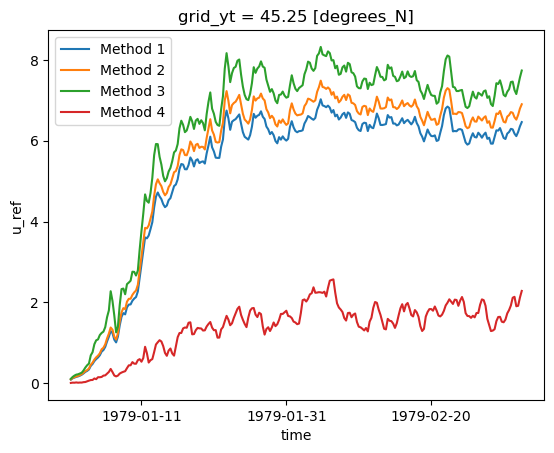

In [31]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

method_1_tu.plot.line(ax=ax,label='Method 1')
method_2_tu.plot.line(ax=ax,label='Method 2')
method_3_tu.plot.line(ax=ax,label='Method 3')
method_4_tu.plot.line(ax=ax,label='Method 4')
ax.legend()